In [26]:
# read pkl file
import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

camera_matrix  = pickle.load(open("cameraMatrix.pkl", "rb"))
print("cameraMatrix:\n", camera_matrix)
dist_coeffs = pickle.load(open("dist.pkl", "rb"))
print("distMatrix:\n", dist_coeffs)

cameraMatrix:
 [[3.96770805e+03 0.00000000e+00 2.48874091e+03]
 [0.00000000e+00 3.94294572e+03 2.11216245e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distMatrix:
 [[ 0.30935866 -1.35000699  0.01816511 -0.00634208  2.23655959]]


In [19]:
from handle_json import read_json

# read the json file
data = read_json("pnp_anno.json")
print(data)

[{'img_name': '0.jpg', 'projection': [[2350, 2592], [2476, 2869], [2439, 1933], [2591, 2058], [2910, 2640], [3160, 2918], [3012, 2000], [3293, 2136]], 'orientation': [-171.33842232, -10.62580706, 6.27302287], 'translation': [0.37451909539842093, 0.382330246212592, -5.343822886892382]}]


In [20]:
import itertools
width = 13.5
height = 15.5
depth = 18

dims = [width/height, height/height, depth/height]

# different combinations w d and h
dims = list(itertools.permutations(dims))

image_points = data[0]["projection"]
image_points = np.array(image_points, dtype=np.float32)

print(dims)

[(0.8709677419354839, 1.0, 1.1612903225806452), (0.8709677419354839, 1.1612903225806452, 1.0), (1.0, 0.8709677419354839, 1.1612903225806452), (1.0, 1.1612903225806452, 0.8709677419354839), (1.1612903225806452, 0.8709677419354839, 1.0), (1.1612903225806452, 1.0, 0.8709677419354839)]


In [21]:
def calculate_error_distance(image_points, PNP_image_points):
    error_distance = 0
    # calculate the error distance
    for i in range(len(image_points)):
        error_distance += np.linalg.norm(image_points[i] - PNP_image_points[i])
    return error_distance

In [22]:
error_distance = np.inf
best_rotation_vector = None
best_translation_vector = None
best_dimensions = None

for i in dims:
    width, height, depth = i[0], i[1], i[2]
    cx= 0
    cy= 0
    cz = 0
    # X axis point to the right
    right = cx + width / 2.0
    left = cx - width / 2.0
    # Y axis point upward
    top = cy + height / 2.0
    bottom = cy - height / 2.0
    # Z axis point forward
    front = cz + depth / 2.0
    rear = cz - depth / 2.0

    # List of 8 vertices of the box
    object_points =  np.array([
        # self.center_location,   # Center
        [left, bottom, rear],  # Rear Bottom Left
        [left, bottom, front],  # Front Bottom Left
        [left, top, rear],  # Rear Top Left
        [left, top, front],  # Front Top Left

        [right, bottom, rear],  # Rear Bottom Right
        [right, bottom, front],  # Front Bottom Right
        [right, top, rear],  # Rear Top Right
        [right, top, front  ],  # Front Top Right

    ], dtype=np.float32)

    # success, rotation_vector, translation_vector = cv.solvePnPRansac(object_points, image_points, camera_matrix, dist_coeffs)
    # success, rotation_vector, translation_vector = cv.solvePnP(object_points, image_points, camera_matrix, dist_coeffs)
    flag = cv.SOLVEPNP_ITERATIVE
    # flag = cv.SOLVEPNP_EPNP
    # flag = cv.SOLVEPNP_RANSAC
    
    # success, rotation_vector, translation_vector = cv.solvePnP(object_points, image_points, camera_matrix, dist_coeffs, flags=flag)
    ret, rotation_vector, translation_vector, reprojectionError = cv.solvePnPGeneric(
                object_points,
                image_points,
                camera_matrix,
                dist_coeffs,
                flags=flag
            )
    # print("Success", success)
    rotation_vector = rotation_vector[0]
    translation_vector = translation_vector[0]
    # rotation_matrix, _ = cv.Rodrigues(rotation_vector)
    # r = R.from_matrix(rotation_matrix)
    # euler_angles = r.as_euler('xyz', degrees=True)  # in degrees
    # print("Euler angles: ", euler_angles)
    
    if not ret:
        continue
    
    # Convert rotation vector to rotation matrix
    # rotation_matrix, _ = cv.Rodrigues(rotation_vector)
        
    # Project the transformed 3D points to 2D using OpenCV's projectPoints
    PNP_image_points, _ = cv.projectPoints(object_points, rotation_vector, translation_vector, camera_matrix, dist_coeffs)
    err_dis = calculate_error_distance(image_points, PNP_image_points)
    
    print("Dims: ", width, height, depth)
    print("current error distance: ", err_dis)
    
    if err_dis < error_distance:
        error_distance = err_dis
        best_rotation_vector = rotation_vector
        best_translation_vector = translation_vector
        best_dimensions = [width, height, depth]
        best_object_points = object_points

print("\n")
print("Best error distance", error_distance)
print("\nBest rotation vector\n", best_rotation_vector)
print("\nBest translation vector\n", best_translation_vector)
        

Dims:  0.8709677419354839 1.0 1.1612903225806452
current error distance:  27.777212619781494
Dims:  0.8709677419354839 1.1612903225806452 1.0
current error distance:  296.83706283569336
Dims:  1.0 0.8709677419354839 1.1612903225806452
current error distance:  506.089168548584
Dims:  1.0 1.1612903225806452 0.8709677419354839
current error distance:  165.52619647979736
Dims:  1.1612903225806452 0.8709677419354839 1.0
current error distance:  734.1970520019531
Dims:  1.1612903225806452 1.0 0.8709677419354839
current error distance:  472.57519340515137


Best error distance 27.777212619781494

Best rotation vector
 [[-2.96383476]
 [-0.18335352]
 [-0.26342211]]

Best translation vector
 [[0.38405037]
 [0.37007352]
 [5.41920379]]


In [23]:
# Project the transformed 3D points to 2D using OpenCV's projectPoints
Best_PNP_image_points, _ = cv.projectPoints(best_object_points, best_rotation_vector, best_translation_vector, camera_matrix, dist_coeffs)

# Step 3: Draw the 3D box on the image
Best_PNP_image_points = Best_PNP_image_points.reshape(-1, 2)  # Reshape to (8, 2) for easier indexing

# print NEW_PNP vs ORIGINAL IMAGE POINTS
print("NEW_PNP vs ORIGINAL IMAGE POINTS: \n")
for i in range(len(Best_PNP_image_points)):
    print(Best_PNP_image_points[i], image_points[i] )

NEW_PNP vs ORIGINAL IMAGE POINTS: 

[2351.0952 2589.0627] [2350. 2592.]
[2476.578  2868.0303] [2476. 2869.]
[2441.5876 1933.2146] [2439. 1933.]
[2591.6904 2055.1963] [2591. 2058.]
[2910.3323 2639.1978] [2910. 2640.]
[3163.9873 2924.596 ] [3160. 2918.]
[3007.3284 2000.295 ] [3012. 2000.]
[3288.2285 2135.8875] [3293. 2136.]


(3888, 5184, 3)


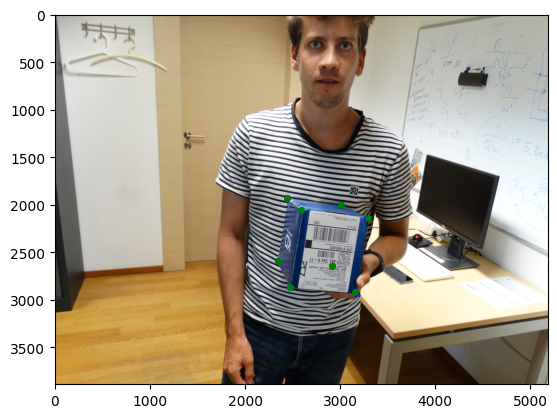

In [24]:
# draw new points on the image with matplotlib
image = plt.imread("data/0.jpg")
height, width, depth = image.shape 
print(image.shape)

for i in range(len(Best_PNP_image_points)):
    plt.plot(int(Best_PNP_image_points[i][0]), int(Best_PNP_image_points[i][1]), 'bo', markersize=4)
    plt.plot(int(image_points[i][0]), int(image_points[i][1]), 'go', markersize=4)
plt.imshow(image)


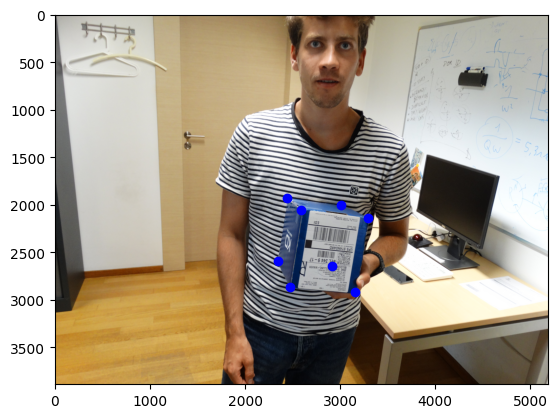

In [25]:
# draw new points on the image with matplotlib
image = plt.imread("data/0.jpg")

for i in range(len(Best_PNP_image_points)):
    plt.plot(int(image_points[i][0]), int(image_points[i][1]), 'bo')
plt.imshow(image)